In [1]:
# import the packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
from statistics import mode
import datetime
from sklearn.metrics.pairwise import cosine_similarity
import geopandas
import rtree
import seaborn as sns
import haversine as hs

# 1 Import data

In [2]:
# import the data into pandas dataframes
hvc_am0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AM0.csv", sep=";")
hvc_ar0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AR0.csv", sep=";")
hvc_customer_reviews = pd.read_csv("../ACRM-GROUP-13/data/HVC_CUSTOMER_REVIEWS.csv", sep=";")
hvc_depot = pd.read_csv("../ACRM-GROUP-13/data/HVC_DEPOT.csv", sep=";")
hvc_hvdayofweek = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVDAYOFWEEK.csv", sep=";")
hvc_hvposition = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVPOSITION_CORRECT.csv", sep=";")
hvc_hvroutetemplate = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVROUTETEMPLATE.csv", sep=";")
hvc_hvvisitoutcome = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITOUTCOME.csv", sep=";")
hvc_hvvisitresult = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITRESULT.csv", sep=";")
hvc_so0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_SO0.csv", sep=";")
hvc_visitresultdetails = pd.read_csv("../ACRM-GROUP-13/data/HVC_VISITRESULTDETAILS.csv", sep=";")

In [3]:
#Data conversion
hvc_hvdayofweek["HVDAYOFWEEK_NRID"] = hvc_hvdayofweek["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"] = hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvroutetemplate["HVDAYOFWEEK_NRID"] = hvc_hvroutetemplate["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["WEEKORDER"] = hvc_hvroutetemplate["WEEKORDER"].astype(int)
hvc_hvvisitoutcome["HVOUTCOME_NRID"] = hvc_hvvisitoutcome["HVOUTCOME_NRID"].astype(int)
hvc_visitresultdetails["HVVISITRESULT_NRID"] = hvc_visitresultdetails["HVVISITRESULT_NRID"].astype(int)
hvc_so0["SO0_NRID"] = hvc_so0["SO0_NRID"].astype(int)
hvc_so0["HVROUTETEMPLATE_NRID"] = hvc_so0["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvvisitresult["DATEONLY"] = pd.to_datetime(hvc_hvvisitresult["DATEONLY"])
hvc_hvvisitresult["VISITDATE"] = pd.to_datetime(hvc_hvvisitresult["VISITDATE"])

# 2 Explore the data

## 2.1 hvc_ar0 

In [4]:
# inspect the first 5 products
hvc_ar0.head(5)


,AR0_NRID,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,20742288286838,Dessert Caramel/14,Verkoopsartikel,Cups,10.9
1,20413488326838,Penalty/16,Verkoopsartikel,Hand Ice,6.5
2,21515648414638,Kriekentaart,Verkoopsartikel,Coffee,7.9
3,20296288686840,Expo met zachte wafel/12,Verkoopsartikel,Individual Dessert,7.3
4,21844652504048,Paaseitjes,Verkoopsartikel,Individual Dessert,7.5


In [5]:
# inspect last 5 products
hvc_ar0.tail(5)

,AR0_NRID,DESCRIPTION,CATEGORY,FAMILY,PRICE
312,23731,Subimba 100 cc.Choc/24,Verkoopsartikel,Cups,9.6
313,23735,Super Krokant/24,Verkoopsartikel,Hand Ice,9.7
314,23739,Maxi Banana/12,Verkoopsartikel,Hand Ice,5.5
315,17492188344852,SoufflÃ© Cointreau/4,Verkoopsartikel,Individual Dessert,8.9
316,20985584414848,Bon 1L roomijs naar keuze,Kortingsbon,NaN,-3.9


In [6]:
# check dtypes
hvc_ar0.dtypes

AR0_NRID         int64
DESCRIPTION     object
CATEGORY        object
FAMILY          object
PRICE          float64
dtype: object

In [7]:
# inspect some descriptive statistics with respect to the description
hvc_ar0["DESCRIPTION"].describe()

count                 317
unique                314
top       Aardbeien vlaai
freq                    2
Name: DESCRIPTION, dtype: object

In [8]:
# inspect some descriptive statistics with respect to the category
hvc_ar0["CATEGORY"].describe()

count                 317
unique                  3
top       Verkoopsartikel
freq                  287
Name: CATEGORY, dtype: object

In [9]:
# inspect some descriptive statistics with respect to the family
hvc_ar0["FAMILY"].describe()

count           275
unique           11
top       Scoop Ice
freq             64
Name: FAMILY, dtype: object

In [10]:
# inspect the total number of products 
len(hvc_ar0["AR0_NRID"].unique())

317

In [11]:
# inspect the proportion of product families
hvc_ar0["FAMILY"].value_counts(normalize=True)

Scoop Ice             0.232727
Hand Ice              0.167273
Cups                  0.134545
Meals                 0.130909
Coffee                0.083636
Ice Cakes             0.083636
Individual Dessert    0.080000
Garniture             0.043636
Assortments           0.029091
BIG                   0.007273
POS inside            0.007273
Name: FAMILY, dtype: float64

In [12]:
# get some descriptive statistics with respect to the price of the products
hvc_ar0["PRICE"].describe()

count    286.000000
mean       7.763112
std        5.948013
min      -25.000000
25%        5.125000
50%        7.600000
75%        9.600000
max       37.000000
Name: PRICE, dtype: float64

In [13]:
# inspect which products had a negative price
hvc_ar0[hvc_ar0["PRICE"] < 0]

,AR0_NRID,DESCRIPTION,CATEGORY,FAMILY,PRICE
21,57367272,"Bon -2,5euro zomermailing07",Kortingsbon,NaN,-2.5
54,54251376,Bon chocolate surprise Utopoli,Kortingsbon,NaN,-5.2
63,62157503,"Bon -7,40 euro",Kortingsbon,NaN,-7.4
64,62315111,Bon duette deluxe/6 bij AK min,Kortingsbon,NaN,-4.2
71,55360457,Bon gratis deco Nieuwsblad/Ver,Kortingsbon,NaN,-4.1
186,21454356698044,"Bon -1,9 euro bij AK 15 euro",Kortingsbon,NaN,-1.9
187,21142456138046,"Bon -4,10euro bij AK van min 2",Kortingsbon,NaN,-4.1
218,52529668,"Bon-6,90euro bij AK van min 35",Kortingsbon,NaN,-7.4
230,53569504,"Bon-3,90euro KVLV 2007",Kortingsbon,NaN,-4.1
231,53614655,Bon -10euro Exellent,Kortingsbon,NaN,-10.0


# 3 Analysis

## 3.1 What are the most frequently bought products?

In [15]:
#group by aggregate
agg_dict = {"QUANTITY": np.sum}
hvc_quantity = hvc_visitresultdetails.groupby("AR0_NRID").agg(agg_dict)
hvc_quantity_top = hvc_quantity.sort_values("QUANTITY", ascending = False).head(5)
hvc_quantity_top

,QUANTITY
AR0_NRID,
23678,12051.0
23716,8725.0
23685,7661.0
23734,4345.0
8609011,3210.0


## 3.2 Which products render the most revenue?


In [16]:
# making the correct table
hvc_ar0_visitresultdetails = pd.merge(hvc_ar0, hvc_visitresultdetails)
hvc_ar0_visitresultdetails

# calculating the revenue
revenue = hvc_ar0_visitresultdetails["QUANTITY"] * hvc_ar0_visitresultdetails["PRICE"]
hvc_ar0_visitresultdetails["REVENUE"] = revenue
agg_dict = {"REVENUE": np.sum}
hvc_revenue = hvc_ar0_visitresultdetails.groupby("AR0_NRID").agg(agg_dict)
hvc_revenue_top = hvc_revenue.sort_values("REVENUE", ascending = False).head(5)
hvc_revenue_top

,REVENUE
AR0_NRID,
23678,89177.4
23716,82887.5
21792988536842,39619.1
23734,36932.5
23742,29991.0


## 3.3 Which products are bought the most in the region of Brussels, Antwerp, ...?

In [17]:
# making the necessary tables
hvc_visitresult_visitresultdetails_so0 = pd.merge(pd.merge(hvc_hvvisitresult, hvc_so0, on = "SO0_NRID"), hvc_visitresultdetails, on = "HVVISITRESULT_NRID")
hvc_visitresult_visitresultdetails_so0_ar0 = pd.merge(hvc_visitresult_visitresultdetails_so0, hvc_ar0, on = "AR0_NRID")
hvc_visitresult_visitresultdetails_so0_ar0_routetemplate = pd.merge(hvc_visitresult_visitresultdetails_so0_ar0, hvc_hvroutetemplate)
hvc_visitresult_visitresultdetails_so0_ar0_routetemplate

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,HVROUTETEMPLATE_NRID,CUST_TYPE,...,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,DESCRIPTION,CATEGORY,FAMILY,PRICE,REGION,WEEKORDER,HVDAYOFWEEK_NRID
0,55681456,719952,23186288605042,2,2021-10-24 12:20:01,2019-05-06,16.90,cash,219019962,Private,...,55681457,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4,C04,1,4
1,55248854,719952,23186288605042,2,2021-10-24 12:46:43,2019-04-22,7.40,cash,219019962,Private,...,55248855,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4,C04,1,4
2,54761459,719952,23186288605042,2,2021-10-24 12:32:05,2019-04-08,7.40,cash,219019962,Private,...,54761460,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4,C04,1,4
3,54354469,719952,23186288605042,2,2021-10-24 17:14:48,2019-03-25,16.90,cash,219019962,Private,...,54354470,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4,C04,1,4
4,52658514,719952,23186288605042,2,2021-10-24 11:43:41,2019-01-28,7.40,cash,219019962,Private,...,52658515,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4,C04,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126773,57628579,56303143,18934048107254,2,2021-10-24 16:23:39,2019-06-26,25.95,cash,289416949,Private,...,57628585,55360457,1.0,Bon gratis deco Nieuwsblad/Ver,Kortingsbon,NaN,-4.1,B02,2,3
126774,57960643,23406672553846,18934048107254,2,2021-10-24 17:35:58,2019-07-07,8.30,cash,289416949,Private,...,57960644,17811288175050,1.0,"2,5 L.Caramelo Crunch (Caddy)",Verkoopsartikel,Scoop Ice,8.3,B02,2,3
126775,60878229,23406672553846,18934048107254,2,2021-10-24 17:48:13,2019-10-13,14.80,cash,289416949,Private,...,60878231,17811288175050,1.0,"2,5 L.Caramelo Crunch (Caddy)",Verkoopsartikel,Scoop Ice,8.3,B02,2,3
126776,57785797,19672260568052,24226444135852,2,2021-10-24 09:27:39,2019-07-02,95.90,tbp,70671404,Catering,...,57785798,18296144533640,4.0,Dessert Vanille/14,Verkoopsartikel,Cups,8.4,C04,1,1


In [18]:
#making the function to return the most bought products with the region as input
def productsregionfct(region):
    hvc_visitresult_visitresultdetails_so0_ar0_routetemplate_sortedquantity = hvc_visitresult_visitresultdetails_so0_ar0_routetemplate[hvc_visitresult_visitresultdetails_so0_ar0_routetemplate["REGION"] == region].sort_values(by = "QUANTITY")
    quantity_act= {"QUANTITY" : np.sum}
    quantity_grouped = hvc_visitresult_visitresultdetails_so0_ar0_routetemplate_sortedquantity.groupby("AR0_NRID").agg(quantity_act)
    quantity_grouped_top = quantity_grouped.sort_values(by = "QUANTITY", ascending = False).head(5)
    regionlist = []
    for index in quantity_grouped_top.index:
        regionlist.append(index)
    return regionlist

In [19]:
#using the created function
topproductsperregion = {}

topproductsperregion["C04"] = productsregionfct("C04")
topproductsperregion["B02"] = productsregionfct("B02")
topproductsperregion["C17"] = productsregionfct("C17")
topproductsperregion["B25"] = productsregionfct("B25")

print(topproductsperregion)

{'C04': [23678, 23716, 23685, 23734, 23714], 'B02': [23678, 23685, 23716, 23721, 23734], 'C17': [23678, 23716, 23685, 23734, 23823], 'B25': [23678, 23716, 23685, 8609011, 23734]}


## 3.4 Are product purchases correlated? Are some products often purchased together?


In [20]:
# In table VISITRESULTDETAILS_NRID find the products with the same AR0_NRID. 
# These are the products that are bought in the same visit.

agg_dict = {"AR0_NRID": np.absolute}
hvc_visitresultdetails_correlatedproducts = hvc_visitresultdetails.groupby("HVVISITRESULT_NRID").agg(agg_dict)


hvc_visitresultdetails_correlatedproducts

#This is also incorporated in our recommendation engine

,AR0_NRID
HVVISITRESULT_NRID,
51973580,23678
51973994,23716
51974162,23782
51974372,23678
51974374,23678
...,...
73924050,23677
73924133,"[46264006, 23734]"
73924150,"[23685, 23693, 23816, 23825, 18224652536642]"


## 3.5 What are the total sales generated for each product family?

In [21]:

agg_dict = {"REVENUE": np.sum}
hvc_revenue_family = hvc_ar0_visitresultdetails.groupby("FAMILY").agg(agg_dict)
hvc_revenue_sorted = hvc_revenue_family.sort_values("REVENUE", ascending = False)
hvc_revenue_sorted

,REVENUE
FAMILY,
Hand Ice,399042.2
Scoop Ice,279254.7
Cups,110634.7
Ice Cakes,62868.9
Assortments,61107.9
Individual Dessert,54172.2
Meals,39075.6
Coffee,31738.7
Garniture,13203.1


## 3.6 Does the weather / seasonal changes have an effect on the total revenue?

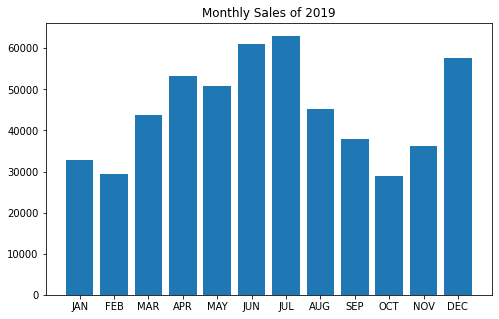

In [22]:
# get the month of each transaction date and store it in new column
hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

# get transactions from 2020 only
transactions_2019 = hvc_hvvisitresult[(hvc_hvvisitresult["DATEONLY"] >= pd.Timestamp(year=2019, day=1, month=1)) & (hvc_hvvisitresult["DATEONLY"] < pd.Timestamp(year=2020, month=1, day=1))]

# get transactions with succesfull outcome
transactions_2019 = transactions_2019[transactions_2019["HVOUTCOME_NRID"] == 2]

# get the total sales for each month
monthly_sales = transactions_2019.groupby("MONTH")["AMOUNT"].sum().reset_index()

# plot barplot

# define figure canvas
plt.figure(figsize=(8, 5))
# plot barplot
plt.bar(x=range(12), height=monthly_sales["AMOUNT"])
# set xticks as the first three letters of the name of each month
month_names = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
plt.xticks(range(12), month_names)
# define title
plt.title("Monthly Sales of 2019")
plt.show()

## Customers that gave bad reviews in 2019

In [24]:
hvc_bad_reviews = hvc_customer_reviews[(hvc_customer_reviews["REVIEW"] == "Not completely satisfied") | (hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")]
customers_bad_reviews = hvc_bad_reviews["SO0_NRID"].to_numpy()

In [25]:
hvc_bad_reviews

,SO0_NRID,REVIEW
7,21013060504838,Not completely satisfied
30,1453559,"Very bad service, very unsatisfied"
43,22422548107054,Not completely satisfied
84,22116348652642,Not completely satisfied
88,1453554,Not completely satisfied
...,...,...
4523,1404774,"Very bad service, very unsatisfied"
4539,24511088324838,Not completely satisfied
4629,24001588345838,"Very bad service, very unsatisfied"
4994,25564876373650,Not completely satisfied


In [9]:
customers_bad_reviews

array([21013060504838,        1453559, 22422548107054, 22116348652642,
              1453554,         875096,        1459339,        1453853,
       19723288383240,        1456875,         725477, 21715164366840,
              1453508,         875073,        1453884,        1454104,
       21434064636240,        1453829,        1400361, 21583956577850,
               875235, 20282468613638, 21886064266840,         875464,
       24615248492240, 23814056296854,         720216,        1395429,
       23366988693444, 23411172533442, 20823376383652, 23922888143242,
               727735,         719853, 21775660237052,        1457653,
              1457182,        1453711,        1454050, 22785948207640,
               875199,       39781389, 21665044446240,         879593,
               877587, 22972272483640,         877246,         874232,
               874243,         877313,         874926, 20943064475840,
               879786,         877506,         877511, 18803468153846,
      

## 3.7 Product Family 

In [26]:
# get the number of products in each product family
products_per_family = hvc_ar0.groupby("FAMILY")["AR0_NRID"].count().reset_index()

In [27]:
#making the correct table
hvc_ar0_visitresultdetails = pd.merge(hvc_ar0, hvc_visitresultdetails)
hvc_ar0_visitresultdetails

#calculating the revenue
revenue = hvc_ar0_visitresultdetails["QUANTITY"] * hvc_ar0_visitresultdetails["PRICE"]
hvc_ar0_visitresultdetails["REVENUE"] = revenue
agg_dict = {"REVENUE": np.sum}
hvc_revenue = hvc_ar0_visitresultdetails.groupby("AR0_NRID").agg(agg_dict)
hvc_revenue_top = hvc_revenue.sort_values("REVENUE", ascending = False).head(5)

agg_dict = {"REVENUE": np.sum}
hvc_revenue_family = hvc_ar0_visitresultdetails.groupby("FAMILY").agg(agg_dict)
hvc_revenue_sorted = hvc_revenue_family.sort_values("REVENUE", ascending = False)
hvc_revenue_sorted

,REVENUE
FAMILY,
Hand Ice,399042.2
Scoop Ice,279254.7
Cups,110634.7
Ice Cakes,62868.9
Assortments,61107.9
Individual Dessert,54172.2
Meals,39075.6
Coffee,31738.7
Garniture,13203.1


In [28]:
products_per_family.sort_values("AR0_NRID")
products_per_family_index = products_per_family.set_index("FAMILY").reindex(hvc_revenue_sorted.index)

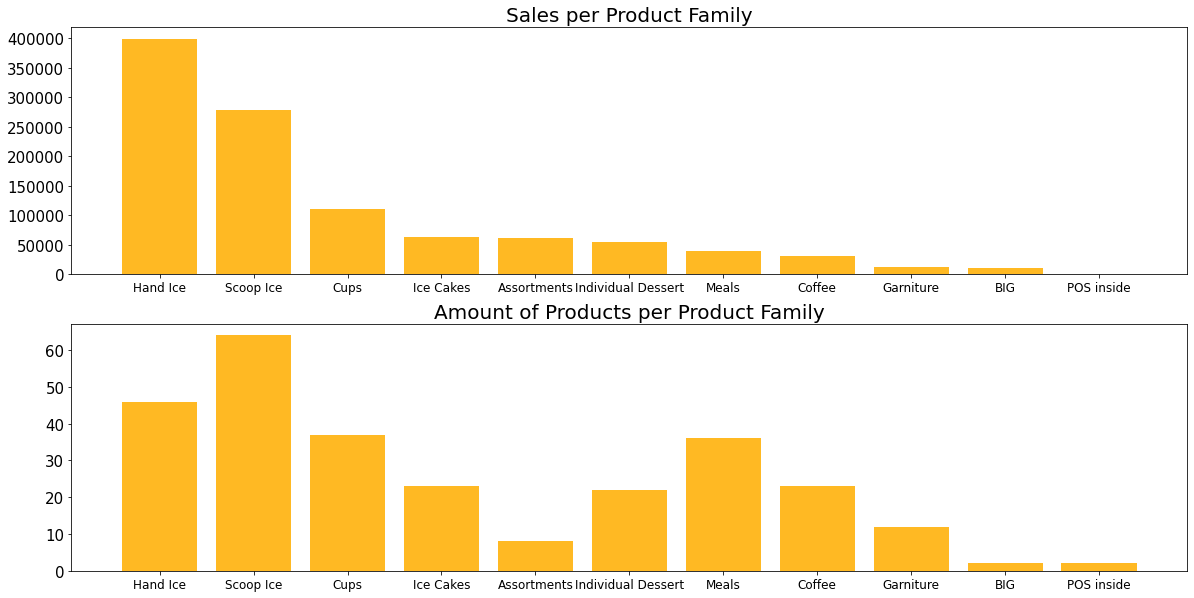

In [29]:
# create subplot
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
# plot barplot
plt.bar(x=range(11), height=hvc_revenue_sorted["REVENUE"], label = "Revenue", color = '#ffb923')
plt.set_color = ("#ffb923")
# set xticks
family_names = []
for index in hvc_revenue_sorted.index:
    family_names.append(index)
plt.xticks(range(11), family_names, fontsize = 12)
plt.yticks(fontsize = 15)
# define title
plt.title("Sales per Product Family", fontsize = 20)

plt.subplot(2,1,2)
# plot barplot
plt.bar(x=range(11), height=products_per_family_index["AR0_NRID"], label = "Products per family", color = '#ffb923')
plt.set_color = ("#ffb923")
# set xticks
plt.xticks(range(11), family_names, fontsize = 12)
plt.yticks(fontsize = 15)
# define title
plt.title("Amount of Products per Product Family", fontsize = 20)
plt.savefig('./Graphs/productfamily.png')
plt.show()



In [30]:
# check the proportion of sold products

hvc_revenue_family

,REVENUE
FAMILY,
Assortments,61107.9
BIG,10240.0
Coffee,31738.7
Cups,110634.7
Garniture,13203.1
Hand Ice,399042.2
Ice Cakes,62868.9
Individual Dessert,54172.2
Meals,39075.6


In [31]:
#check the top products per family so we can drop certain products that do not generate enough
# sidenote with the graph about products per family and revenue per family

agg_dict = {'REVENUE': np.sum}
hvc_revenue_product = hvc_ar0_visitresultdetails.groupby('AR0_NRID').agg(agg_dict)

hvc_revenue_product_family = pd.merge(hvc_revenue_product,hvc_ar0, on = "AR0_NRID")
hvc_revenue_product_family = hvc_revenue_product_family[hvc_revenue_product_family['FAMILY'].notna()]

def topproductsperfamily(specificfamily):
    hvc_revenue_product_family_Specificfamily = hvc_revenue_product_family[hvc_revenue_product_family["FAMILY"] == specificfamily].sort_values("REVENUE", ascending = False)
    total_revenue_family = hvc_revenue_product_family[hvc_revenue_product_family["FAMILY"] == specificfamily]["REVENUE"].sum()
    frequency_family = []
    for index, row in hvc_revenue_product_family_Specificfamily.iterrows():
        frequency_family.append(round((100 * row.REVENUE)/total_revenue_family,2))
    hvc_revenue_product_family_Specificfamily["FREQUENCY_OF_REVENUE"] = frequency_family
    hvc_revenue_product_family_Specificfamily.set_index("AR0_NRID", inplace = True)
    return hvc_revenue_product_family_Specificfamily[["REVENUE", "FREQUENCY_OF_REVENUE"]]
scoop_ice = topproductsperfamily("Scoop Ice")
scoop_ice[scoop_ice["FREQUENCY_OF_REVENUE"] < 0.1]


,REVENUE,FREQUENCY_OF_REVENUE
AR0_NRID,,
290318679,258.3,0.09
23702,257.3,0.09
23704,166.0,0.06
23701,141.1,0.05
23703,107.9,0.04
17811288175050,49.8,0.02
18424244393052,33.2,0.01
23712,33.2,0.01
19864988676644,32.4,0.01


## 3.8 Recommendation Engine

#### Preparations

In [32]:
#making the necessary tables
hvc_visitresult_visitresultdetails_so0 = pd.merge(pd.merge(hvc_hvvisitresult, hvc_so0, on = "SO0_NRID"), hvc_visitresultdetails, on = "HVVISITRESULT_NRID")
hvc_visitresult_visitresultdetails_so0_ar0 = pd.merge(hvc_visitresult_visitresultdetails_so0, hvc_ar0, on = "AR0_NRID")
hvc_visitresult_visitresultdetails_so0_ar0_routetemplate = pd.merge(hvc_visitresult_visitresultdetails_so0_ar0, hvc_hvroutetemplate)
hvc_visitresult_visitresultdetails_so0_ar0_routetemplate
def productsregionfct(region):
    hvc_visitresult_visitresultdetails_so0_ar0_routetemplate_sortedquantity = hvc_visitresult_visitresultdetails_so0_ar0_routetemplate[hvc_visitresult_visitresultdetails_so0_ar0_routetemplate["REGION"] == region].sort_values(by = "QUANTITY")
    quantity_act= {"QUANTITY" : np.sum}
    quantity_grouped = hvc_visitresult_visitresultdetails_so0_ar0_routetemplate_sortedquantity.groupby("AR0_NRID").agg(quantity_act)
    quantity_grouped_top = quantity_grouped.sort_values(by = "QUANTITY", ascending = False).head(5)
    regionlist = []
    for index in quantity_grouped_top.index:
        regionlist.append(index)
    return regionlist

In [33]:
transactions_details_df = pd.merge(left=hvc_hvvisitresult, right=hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner")

In [34]:
# put the column "AR0_NRID" of hvc_visitresultdetails_correlatedproducts in a list 
# so that it is easier to work with

# get unique transactions
trans_ids = transactions_details_df["HVVISITRESULT_NRID"].unique().tolist()

# initialize container
trans_products = []

# loop through all the transactions
for trans_id in trans_ids:
    # get unique products that were bought during transaction
    products = transactions_details_df[transactions_details_df["HVVISITRESULT_NRID"] == trans_id]["AR0_NRID"].unique().tolist()
    # add to container
    trans_products.append(products)

In [35]:
#function to get the most correlated product of a product
def get_correlated_product(product_id):    
    # initialize empty container
    other_products = []
    # loop through the transactions
    for products in trans_products:
        # check if product_id was bought in transaction
            if product_id in products:
            # loop through the products that were bought in that transaction
                for product in products:
                    if product != product_id:
                        # add product to container
                        other_products.append(product)
    
    return mode(other_products)

In [36]:
# define a function that accepts a customer id, the transactions data, transactions details data and product data
def get_products_customer(cust_id):
    # join transactions with transaction details with products
    transactions_products = hvc_hvvisitresult.merge(hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner") \
                                        .merge(hvc_ar0, on="AR0_NRID", how="inner")
    # get transactions of customer 
    transactions_products_cust = transactions_products[transactions_products["SO0_NRID"] == cust_id]
    # only get transactions of succesfull visits
    transactions_products_cust = transactions_products_cust[transactions_products_cust["HVOUTCOME_NRID"] == 2]
    # return
    return transactions_products_cust["AR0_NRID"].unique()

In [37]:
#function to get the region of a customer based on the route he is in
def get_region_customer(customerid):
    #merge the correct df
    hvc_so0_routetemplate = pd.merge(hvc_so0, hvc_hvroutetemplate, on = "HVROUTETEMPLATE_NRID", how = "inner")
    #set the index for loc
    hvc_so0_routetemplate = hvc_so0_routetemplate.set_index("SO0_NRID")
    #get the region out of the df
    region = hvc_so0_routetemplate.loc[customerid]["REGION"]
    return region

In [38]:
#function to get correlated products of customer based on previous product purchases
def get_top_correlated_products(cust_id):
    #initialize local variables
    products = get_products_customer(cust_id)
    correlated_products = []
    #get correlated products out of function and list of bought products
    for product in products:
            correlated_products.append(get_correlated_product(product))
    correlated_products = np.unique(correlated_products)
    return correlated_products

In [39]:
#Make recency, freq and monetary value table of all customers
#Recency
rec = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 2].groupby("SO0_NRID")["DATEONLY"].max().reset_index()
rec["REC"] = rec["DATEONLY"].apply(lambda x: (datetime.datetime.now() - x).days)
rec = rec.drop("DATEONLY", axis = 1)

#Frequency
freq = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 2].groupby("SO0_NRID")["HVVISITRESULT_NRID"].count().reset_index()
freq = freq.rename(columns = {"HVVISITRESULT_NRID": "FREQ"})

#Monetary Value
mon = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 2].groupby("SO0_NRID")["AMOUNT"].sum().reset_index()
mon = mon.rename(columns = {"AMOUNT": "MON"})

#Join all the tables
cust_info = rec.merge(freq, on = "SO0_NRID", how = "inner").merge(mon, on = "SO0_NRID", how = "inner")

In [40]:
# define function to get most similar customer
def get_most_similar_cust(cust_id):
    try:
        # initialize cosine dist
        best_cos_sim = 0
        # initialize most similar cust
        sim_cust= None

        # get feature vector of customer
        feature_vector_x = np.array(cust_info[cust_info["SO0_NRID"] == cust_id][["MON", "FREQ", "REC"]])

        # loop through other customers 
        for i in range(len(cust_info)):

            # get cust id
            other_cust_id =int(cust_info["SO0_NRID"].iloc[i])

            # make sure we only get other customers
            if other_cust_id != cust_id:

                # get feature vector from other customer
                feature_vector_y = np.array(cust_info[cust_info["SO0_NRID"] == other_cust_id][["MON","FREQ","REC"]])
                # get cosine similarity
                cos_sim = cosine_similarity(feature_vector_x,feature_vector_y)[0][0]
                # check if similarity is higher than current highest similarity and update sim_cust and best_cost_sim
                if cos_sim > best_cos_sim:
                    best_cos_sim = cos_sim
                    sim_cust = other_cust_id

        # return cosine similarity and customer id
        return sim_cust
    except:
        return cust_id

In [41]:
def get_recommendedproducts_similarcust(cust_id):
    transactions_details_df = pd.merge(left=hvc_hvvisitresult, right=hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner")
    #get most similar customer
    similar_cust = get_most_similar_cust(cust_id)
    if(similar_cust != cust_id):
        # get all products bought by customer
        products_cust = set(transactions_details_df[transactions_details_df["SO0_NRID"] == cust_id]["AR0_NRID"])
        # get all products bought by most similar customer
        products_other_cust = set(transactions_details_df[transactions_details_df["SO0_NRID"] == similar_cust]["AR0_NRID"])
        # get products bought by most similar customer but not yet by customer
        return np.array(list(products_other_cust.difference(products_cust)))
    else:
        return cust_id

#### Engine

In [42]:
def recommendation_engine(cust_id):
    #initialize recommended products
    recommended_products = []
    #get best correlated products based on previous products
    correlated_products = get_top_correlated_products(cust_id)
    #get most bought products of region customer
    top_region_customer = productsregionfct(get_region_customer(cust_id))
    #get recommended products of most similar customer
    if(isinstance(get_recommendedproducts_similarcust, str)):
        return print("The customer is not visited")
    else:
        recommended_similar_cust = get_recommendedproducts_similarcust(cust_id)
        #check the sizes + check if there is an intercept between the arrays
        if(correlated_products.size != 0):
            if(np.intersect1d(np.intersect1d(correlated_products, recommended_similar_cust), top_region_customer).size != 0):
                recommended_products = np.intersect1d(np.intersect1d(correlated_products, recommended_similar_cust), top_region_customer)
                return print("Recommended products based on similar customers, region and correlated products:",recommended_products)
            else:
                print("There is no intersect with region, most correlated products and similar customer products.")
                if((np.intersect1d(correlated_products, recommended_similar_cust).size != 0) & (np.intersect1d(correlated_products, top_region_customer).size != 0)):
                    recommended_products_simcust = np.intersect1d(correlated_products, recommended_similar_cust)
                    recommended_products_region = np.intersect1d(correlated_products, top_region_customer)
                    return print("Recommended products based on similar customers and correlated products:", recommended_products_simcust,"\nRecommended products based on region and correlated products:", recommended_products_region)
                elif(np.intersect1d(correlated_products, recommended_similar_cust).size != 0):
                    recommended_products = np.intersect1d(correlated_products, recommended_similar_cust)
                    return print("Recommended products based on similar customers and correlated products:",recommended_products)
                elif(np.intersect1d(correlated_products, top_region_customer).size != 0):
                    recommended_products = np.intersect1d(correlated_products, top_region_customer)
                    return print("Recommended products based on region and correlated products:",recommended_products)
        else:
            #customer did not buy anything, check region
            print("Customer did not buy anything, we recommend the regional products.")
            recommended_products = top_region_customer
            return print("Recommended products are:",recommended_products)

In [43]:
recommendation_engine(870975)

Recommended products based on similar customers, region and correlated products: [23716]
